Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Радует, что ноутбук хорошо структурирован. Приятно проверять такие работы!
* В работе допущено несколько ошибок. Однако, их исправление не займет много времени.
* Я оставил несколько советов. Пожалуйста, обрати на них внимание.
* Жду новую версию. Удачи в исправлениях!


<div class="alert alert-block alert-success">
<b>Привет! Переделал</b> 
</div>

### <font color='orange'>Общее впечатление (ревью 2)</font>
* После исправлений работа значительно улучшилась, молодец!
* В целом, меня очень порадовало, что ты используешь много графиков в своей работе. Продолжай в том же духе!
* Этот проект зачтен. Удачи в дальнейшем обучении!

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error as mse, make_scorer
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

register_matplotlib_converters()
%matplotlib inline

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [59]:
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=0)

In [60]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [61]:
data.sort_index(inplace=True)

In [62]:
data = data.resample('1H').sum()

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [64]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Вывод: <a name='findings_1'></a>

Данные реземпированы по часу и проверены на отсутствие пропусков и аномальных значений. Итоговое количество объектов 4416.

<div class="alert alert-block alert-success">
<b>Успех:</b> Загрузка и первичных анализ сделаны хорошо. Ресемплинг проведен корректно.
</div>

# 2. Анализ

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было визуализировать сам ряд тоже.
</div>

#### Разложим данные 

In [65]:
decompose = seasonal_decompose(data)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


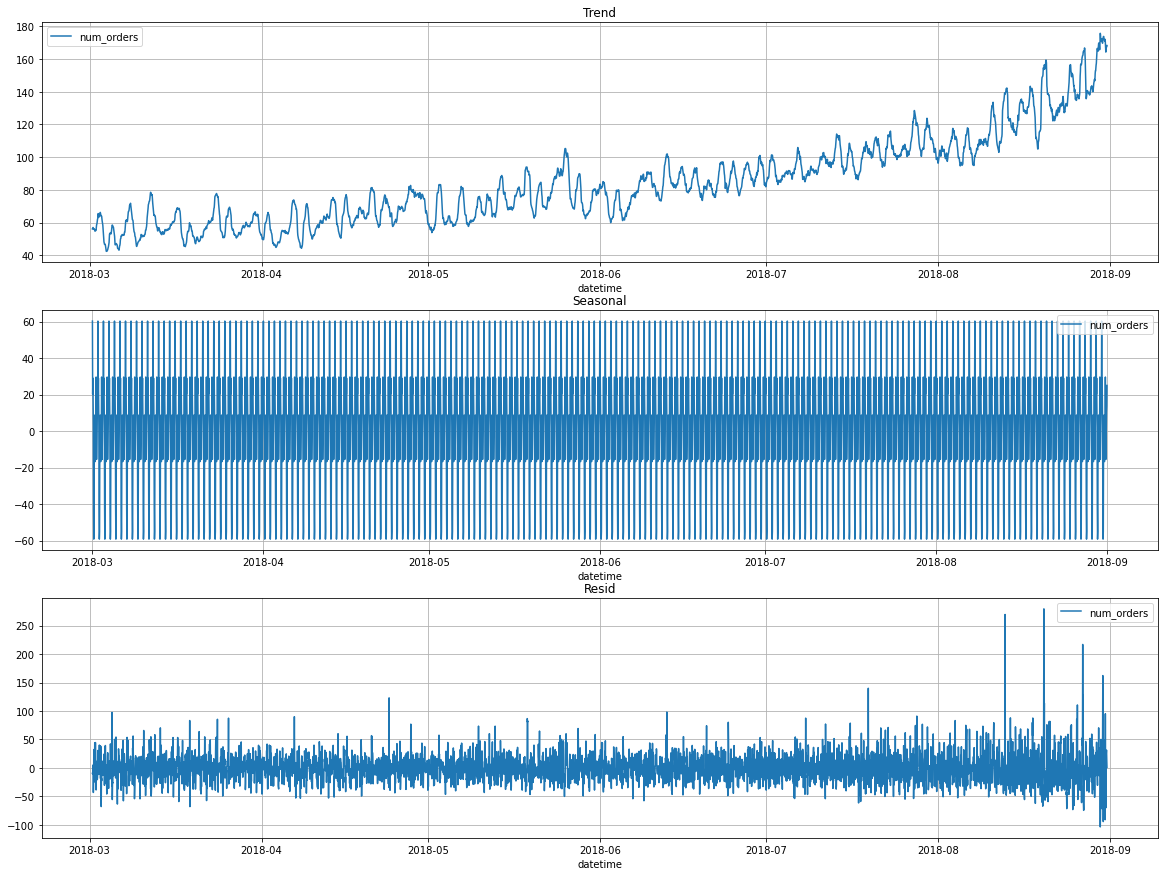

In [66]:
f, ax = plt.subplots(nrows=3, figsize=(20, 15));
sns.lineplot(data=decompose.trend, ax=ax[0]);
ax[0].grid()
ax[0].set_title('Trend')
sns.lineplot(data=decompose.seasonal, ax=ax[1]);
ax[1].grid()
ax[1].set_title('Seasonal')
sns.lineplot(data=decompose.resid, ax=ax[2]);
ax[2].grid()
ax[2].set_title('Resid')
f.show()

Мы видим растущий тренд и дневную сезонность. Причет тренд растет не линейно, 
скорее рост больше похож на экспоненциальный. При таком росте чтобы добиться желаемого результата max(rmse)=48 
на тестовой выборке в 10% важно не разделять данные на валидационную выборку.
И чем больше будет тестовая выборка тем хуже она будет предсказываться

<div class="alert alert-block alert-success">
<b>Успех:</b> Графический анализ тренда и сезонности проведен корректно. С выводами абсолютно согласен!
</div>

С остатками мы ничего делать не будем, просто посмотрим на их распределение

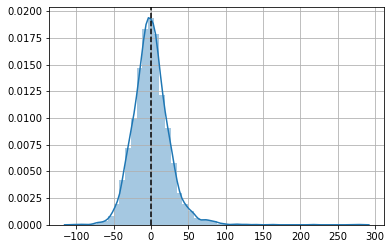

In [67]:
ax = sns.distplot(decompose.resid.dropna())
plt.axvline(0, color="k", linestyle="--");
ax.grid()

In [68]:
decompose.resid.std()

num_orders    24.696896
dtype: float64

Остатки распределены нормально со средним в 0 и стандартным отклонением 25

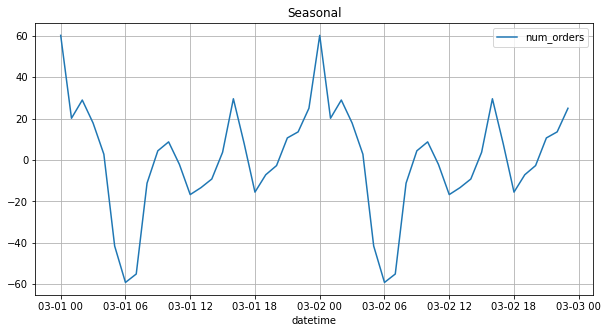

In [69]:
plt.figure(figsize=(10, 5));
ax = sns.lineplot(data=decompose.seasonal['2018-03-01':'2018-03-02'], ax=plt.gca());
ax.grid()
ax.set_title('Seasonal')
plt.show()


По графику сезонности можно увидеть, что основной пик приходится на полночь, а оновной провал - это 6 часов утра

План:
1. Будем строить план отталкиваясь от следующих моделей:
    * NeuralNetwork
    * LGBMRegressor
    * RandomForestRegressor
2. Добавим длполнительные признаки такие как месяц, день, час, сдвиги значений и скользящую среднюю
3. Для линейной регресси важно, что бы все признаки были взвешены и не коррелированы поэтому применем StandardScaler и проверим на корреляцию.
4. Для бустинга категориальыне признаки, такие как month, day, dayofweek, hour,  менять не нужно.

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что построил план!
</div>

Напишем функцию для добавления признаков.

In [70]:
def add_features(data: pd.DataFrame, max_lag: int, moving_average_per: int):
     
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(periods=lag)
        
    data['moving_average'] = data['num_orders'].shift().rolling(moving_average_per).mean()

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было определить функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла старый.
</div>

In [71]:
max_lag = 15
moving_average_per = 15
add_features( data, max_lag, moving_average_per)

In [72]:
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,moving_average
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


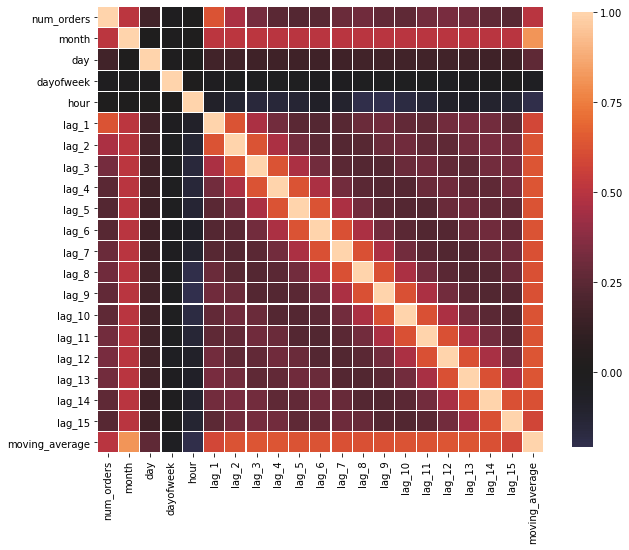

In [73]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), center=0, square=True, linewidths=.1, cbar_kws={"shrink": .8}, ax=plt.gca())
plt.show()

Высокая корреляция между месяцем и скользящей средней. Обусловленно тем, что скользящее среднее растет на протяжении года. Вероятно от месяца будет лучше избавится т.к. он несет в себе меньше информации чем скользящая средняя. С целевым признаком больше всех коррелирует lag_1 т.к. он находится всего в одном шаге.

In [74]:
train_data, test_data = train_test_split(data, train_size=.9, shuffle=False)

In [75]:
 train_data = train_data.dropna()

In [76]:
y_train = train_data['num_orders']
y_test = test_data['num_orders']

X_train = train_data.drop('num_orders', axis=1)
X_test = test_data.drop('num_orders', axis=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3959, 20), (442, 20), (3959,), (442,))

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что напечатал размеры получившихся наборов. Иногда это помогает избежать ошибок.
</div>

In [77]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

<div class="alert alert-block alert-success">
<b>Успех:</b> Радует, что ты не забыл про нормализацию признаков.
</div>

## Вывод: <a name='findings_2'></a>
1. После разложения данных на тренды и сезонности выявлен нелинейный тренд вверх на протяжении всего временного отрезка. Так же  обнаружена дневная сезонность с 6 утра до 12 вечера наблюдается рост заявок, после 12 идет на спад. Анализ отстатков от разложения данных показал, что остатки распределены нормально со средним равным 0 и стандартным отклонением равным 25.
2. Добалены признаки month, day, dayofweek, hour добавлены смещенные значения целевого признака от 1 до 15, добавлена скользящая средняя с периодом 15. 
3. Данные поделены на тренировочную и тестовую выборки, признаки стандартизированы

# 3. Обучение

In [78]:
def draw_plots(train_predicts):
    f, ax = plt.subplots(ncols=2, figsize=(20, 5))
    sns.lineplot(data=y_train.iloc[0: 72].values, ax=ax[0], label='Ground truth')
    sns.lineplot(data=train_predicts[0: 72], ax=ax[0], label='Predicts')
    ax[0].grid()
    ax[0].set_title('Train start')
    ax[0].legend()
    sns.lineplot(data=y_train.iloc[-72: ].values, ax=ax[1], label='Ground truth')
    sns.lineplot(data=train_predicts[-72: ], ax=ax[1], label='Predicts')
    ax[1].grid()
    ax[1].set_title('Train end')
    ax[1].legend()
    f.show()

In [79]:
# Напишем функцию rmse
rmse = lambda *args, **kwargs: mse(*args, **kwargs)**0.5
rmse_score = make_scorer(rmse, greater_is_better=False)

Т.к. мы знаем что у нас постоянно растущий тренд для проверки адекватности возьмем признак самый скоррелированный с целевым признаком, lag_1 (предшествующее значение целевого признака)

In [80]:
# Будем сохранять результаты обучения
rmse_history = pd.DataFrame()

#### DummyModel

In [81]:
train_predicts = train_data['lag_1']
rmse_history.loc['dummy', 'train'] = rmse(y_train, train_predicts)

print('training RMSE:', rmse_history.loc['dummy', 'train'])

training RMSE: 36.1709372450752


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


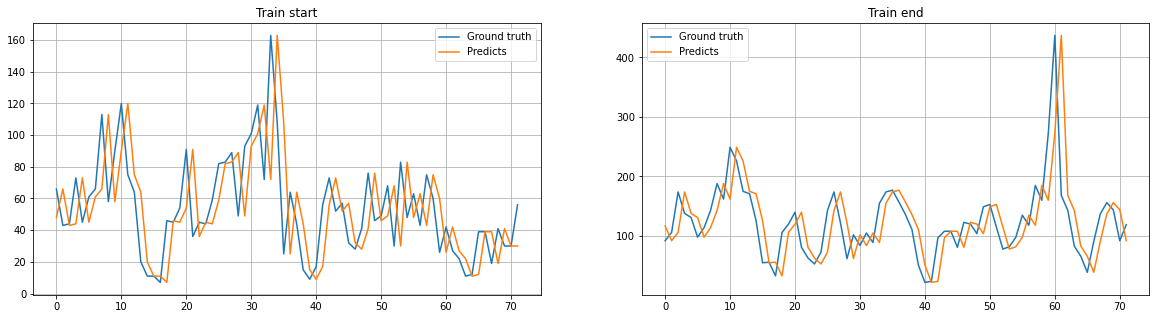

In [82]:
draw_plots(train_predicts.values)

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что начала с бейзлайн модели!
</div>

## LinearRegression <a name='linearregression'></a>

In [83]:
""""linear_scores = cross_validate(LinearRegression(), X_train_scal,  y_train, scoring=rmse_score, return_train_score=True,
cv=3)
linear_scores"""

'"linear_scores = cross_validate(LinearRegression(), X_train_scal,  y_train, scoring=rmse_score, return_train_score=True,\ncv=3)\nlinear_scores'

<div class="alert alert-block alert-success">
<b>Исправил</b>  
</div>

In [84]:
linear_scores = cross_validate(LinearRegression(), X_train_scal,  y_train, scoring=rmse_score, return_train_score=True,
cv = TimeSeriesSplit(n_splits=5))
linear_scores

{'fit_time': array([0.00199461, 0.00299239, 0.00199413, 0.0039885 , 0.00398779]),
 'score_time': array([0.00099659, 0.00099659, 0.00099897, 0.        , 0.00099754]),
 'test_score': array([-2.19102817e+13, -2.83148880e+01, -2.97565738e+01, -3.12386179e+01,
        -3.88940125e+01]),
 'train_score': array([-24.05027168, -25.24702508, -26.11623405, -26.97392056,
        -27.79632046])}

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Нельзя использовать стандартную кросс-валидацию с временными рядами. Нужно использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">TimeSeriesSplit</a> в параметре 'cv'.
</div>

In [85]:
linear_model = LinearRegression()
linear_model.fit(X_train_scal, y_train)
train_predicts = linear_model.predict(X_train_scal)

rmse_history.loc['linear_regression', 'train'] = rmse(y_train, train_predicts)
print('training RMSE:', rmse_history.loc['linear_regression', 'train'])

training RMSE: 29.830561711091736


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


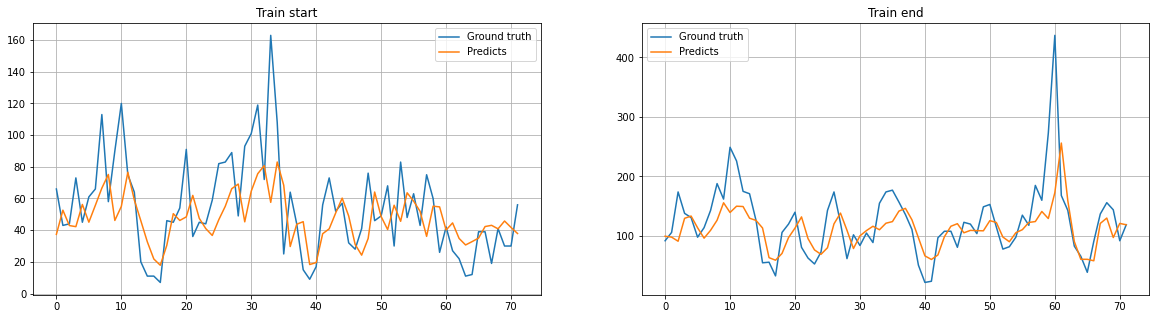

In [86]:
draw_plots(train_predicts)

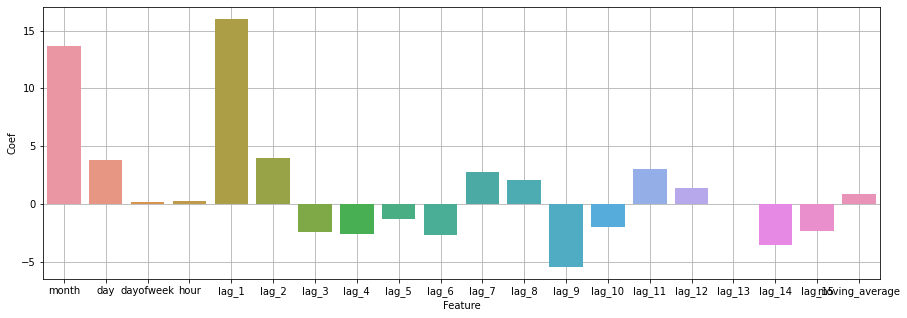

In [87]:
coef = pd.DataFrame(zip(linear_model.coef_, X_train.columns))
plt.figure(figsize=(15, 5))
ax = sns.barplot(y=0, x=1, data=coef, zorder=3)
ax.grid(zorder=0)
ax.set_xlabel('Feature')
ax.set_ylabel('Coef')
plt.show()

Видно, что основной признак оказался lag_1, модель его чуть отмасштабировала ну и следующий признак это month. Все из-за сильной корреляции. Попробуем удалить эти признаки и посмотреть результаты.

In [88]:
new_X = pd.DataFrame(X_train_scal, columns=X_train.columns)
new_X = new_X.drop(['lag_1', 'month'], axis=1)

In [89]:
linear_without_lag = LinearRegression()
linear_without_lag.fit(new_X, y_train)
train_predicts = linear_without_lag.predict(new_X)

rmse_history.loc['linear_without_lag', 'train'] = rmse(y_train, train_predicts)
print('training RMSE:', rmse_history.loc['linear_without_lag', 'train'])

training RMSE: 30.639987256415836


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


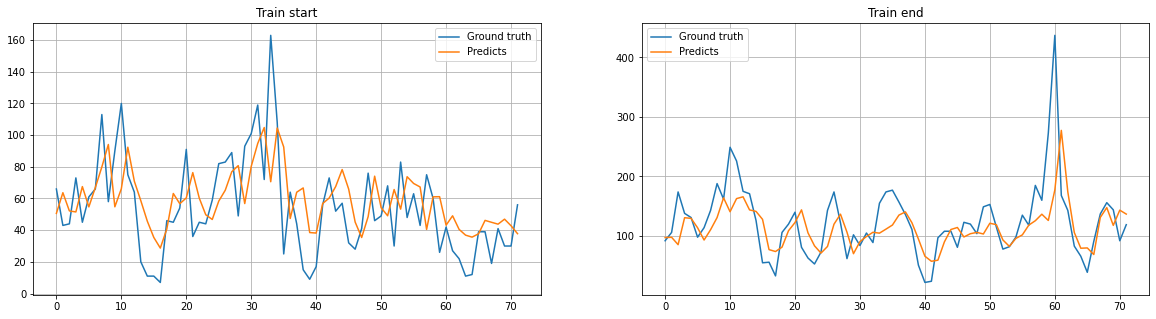

In [90]:
draw_plots(train_predicts)

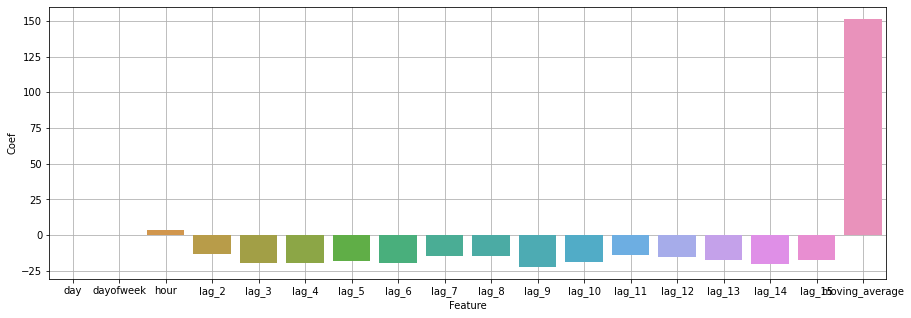

In [91]:
coef = pd.DataFrame(zip(linear_without_lag.coef_, new_X.columns))
plt.figure(figsize=(15, 5))
ax = sns.barplot(y=0, x=1, data=coef, zorder=3)
ax.grid(zorder=0)
ax.set_xlabel('Feature')
ax.set_ylabel('Coef')
plt.show()

Все логично, теперь на первое место вышла moving_averange.

## LGBMRegressor <a name='lgbmregressor'></a>

In [95]:
%%time
 
param = {
         'max_depth': np.arange(-1, 20, 2),
         'num_leaves': np.arange(22, 33, 2), 
         }

estimator = lgb.LGBMRegressor(n_estimators=1000,)
lgb_model = GridSearchCV(estimator, param, scoring=rmse_score, cv = TimeSeriesSplit(n_splits=5))
lgb_model.fit(X_train, y_train)

Wall time: 5min 14s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=1000, n_jobs=-1,
                                     num_leaves=31, objective=None,
                                     random_stat..._alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([-1,  1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Молодец, что не забыл про настройку параметров, но здесь тоже стоит применить TimeSeriesSplit.
</div>

In [96]:
lgb_model.best_score_, lgb_model.best_params_

(-25.280957926566938, {'max_depth': 13, 'num_leaves': 26})

In [97]:
train_predicts = lgb_model.predict(X_train)

rmse_history.loc['lgb_model', 'train'] = rmse(y_train, train_predicts)
print('training RMSE:', rmse_history.loc['lgb_model', 'train'])

training RMSE: 1.4029341269902098


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


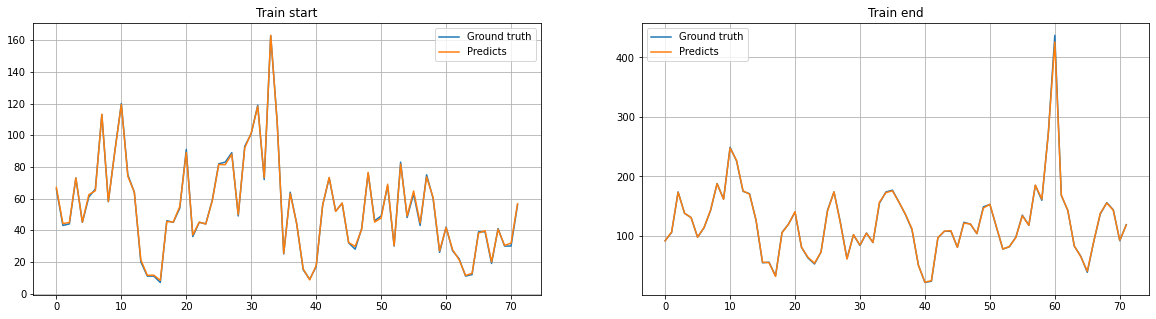

In [98]:
draw_plots(train_predicts)

## RandomForestRegressor <a name='randomforestregressor'></a>

In [99]:
%%time

params = {'n_estimators': np.arange(10, 101, 10),
          'min_samples_split': np.arange(2, 11, 2),
          'min_samples_leaf': np.arange(1, 5)}

estimator_model = RandomForestRegressor(bootstrap=False, random_state=42)
forest_model = GridSearchCV(estimator_model, params, scoring=rmse_score, cv = TimeSeriesSplit(n_splits=5), n_jobs=-1)
forest_model.fit(X_train, y_train)

Wall time: 4min 24s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_...
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
 

In [100]:
forest_model.best_score_, forest_model.best_params_

(-31.386944907886765,
 {'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 40})

In [101]:
train_predicts = forest_model.predict(X_train)

rmse_history.loc['forest_model', 'train'] = rmse(y_train, train_predicts)
print('training RMSE:', rmse_history.loc['forest_model', 'train'])

training RMSE: 13.205353623606849


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


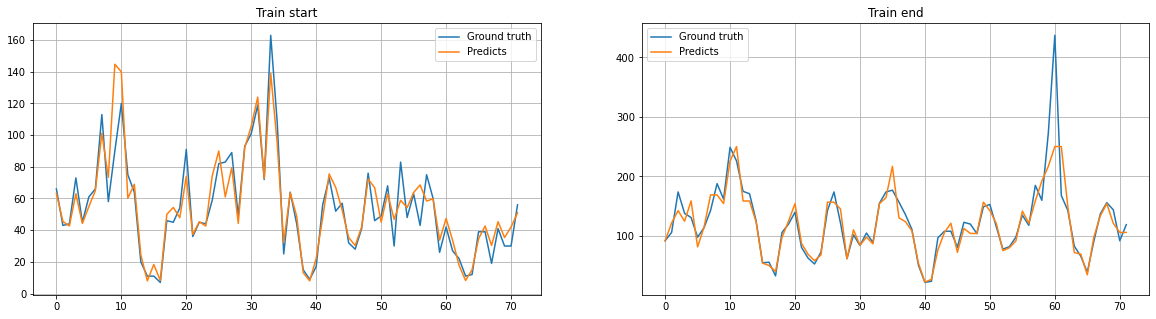

In [102]:
draw_plots(train_predicts)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


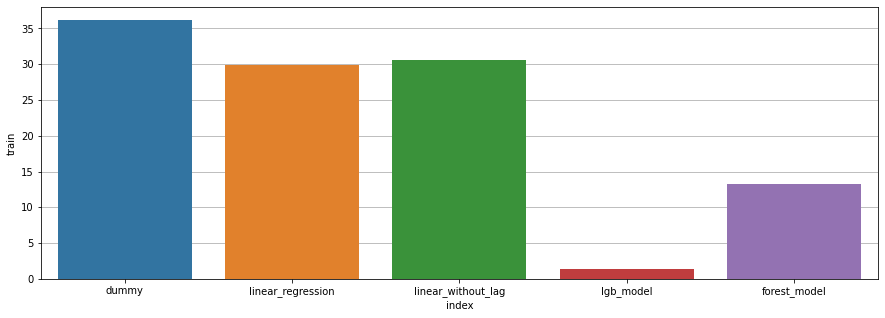

In [103]:
f, ax = plt.subplots(figsize=(15, 5));
sns.barplot(y='train', x='index', data=rmse_history.reset_index(), ax=ax, zorder=3);
ax.grid(axis='y', zorder=0)
f.show();

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Аналогичная ошибка.
</div>

## Вывод: <a name='findings_3'></a>

Лушчей моделью оказалась LGBMRegressor со значениями RMSE: 
    * на тренировочных данных 0.89; 
    * на ваоидационных данных 25.1. 
    
На втором месте RandomForestRegressor со значениями RMSE: 
    * на тренировочных данных 13.2; 
    * на валидационных данных 33.21. 

По графикам видно, что LGBMRegressor полность выучил данные, а RandomForest только начал переобучаться, но все равно значение на RMSE не плохое

# 4. Тестирование

Проверить Dummy_model и lgb_model на тестовых данных

In [43]:
predicts = X_test['lag_1']
print('testing RMSE:', rmse(y_test, predicts))

testing RMSE: 58.856486242815066


In [44]:
predicts = lgb_model.predict(X_test)
print('testing RMSE:', rmse(y_test, predicts))

testing RMSE: 41.60660543818022


## Вывод: <a name='findings_3'></a>

LGBMRegressor Показал значения RMSE: 41.6. Хотя на кросс-валидации выдавал занчение 25.1. Это обусловлено тем, что тестовые данные отличаются от тренировочных тем, что на тестовых данных тренд растет быстрее.

<div class="alert alert-block alert-success">
<b>Успех:</b> Тебе удалось добиться требуемого качества, но после корректной натсройки параметров оно может еще больше улучшиться.
</div>

# Выводы: <a name='findings'></a>
1. Данные преобразованы по часу и проверены на отсутствие пропусков и аномальных значений.
2. Проведен анализ данных. 
    * После разложения данных на тренды и сезонности выявлен нелинейный тренд вверх на протяжении всего временного отрезка. 
    * Так же обнаружена дневная сезонность с 6 утра до 12 вечера наблюдается рост заявок, после 12 идет на спад.
    * Анализ отстатков от разложения данных показал, что остатки распределены равномерно со средним равным 0 и стандартным отклонением равным 25.
3. Добалены признаки month, day, dayofweek, hour добавлены смещенные значения целевого признака от 1 до 15, добавлена скользящая средняя с периодом 15.
4. Данные поделены на тренировочную и тестовую выборки, признаки стандартизированы для линейной регрессии
5. Для экспериментов были выбраны следующие модели:
    * LinearRegression
    * LGBMRegressor
    * RandomForestRegressor
6. Лушчей моделью оказалась LGBMRegressor а на втором месте RandomForestRegressor:

|model name|Train RMSE|Valid RMSE|
|----------|:----------:|:----------:|
|FGBMRegressor|0.89|25.1|
|RandomForestRegressor|13.2|33.21|

7. Финальной моделью была выбрана LGBMRegressor, а для проверки на адекватность выбрана модель с запаздыванием
8. На тестовой выборке модель с запаздыванием показала RMSE 58.9, а RGBMRegressor показал значние 41.6

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48